ERROR 1: PROJ: proj_create_from_database: Open of /home/debasish/anacondainstaller/ENTER/envs/py310/share/proj failed


All imports successful


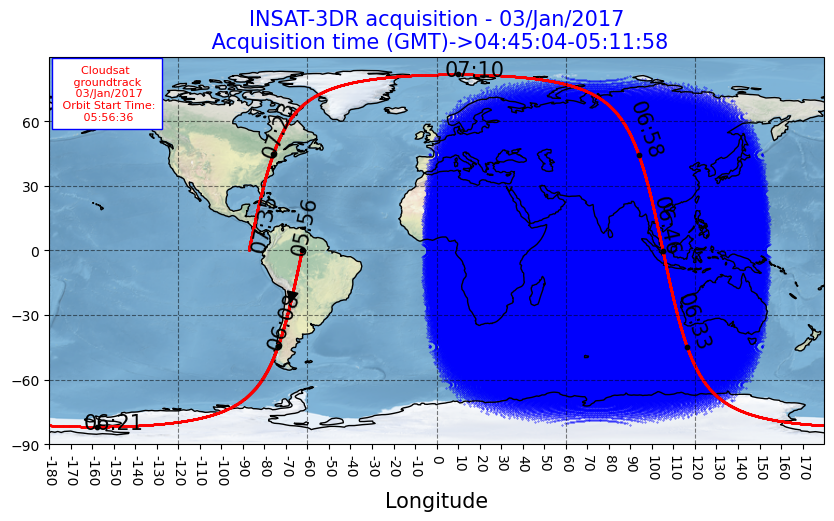

In [1]:
This notebook has 3 cells. In the first 2 cells, I saw the timelines of both satellites and didn't approve the collocation. In the 3rd cell, I did
import numpy as np
import matplotlib.pyplot as plt
import h5py
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
import pandas as pd
from pyhdf.SD import SD, SDC
from pyhdf import HDF, VS, V
from time import gmtime, strftime
import datetime
import time
import geopy.distance
import os
import sys

import geopy
#Code running in interactive mode
print("All imports successful")

insatfilepath = r'/data/debasish/insatdata/l1b/2017/jan2017/day03/3RIMG_03JAN2017_0445_L1B_STD_V01R00.h5'
csatfilepath= r'/data/debasish/cloudsatdata/cldclasslidar/2017/2017jan/003/2017003055636_56841_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E06_F01.hdf'

def groundtrackplotter(pathorfile,c='r', timestamp=True, passedaxis=None, baseimage=True, text=None, s=0.51,linewidths=0.51,arrow=True,arrow_color='black',arrow_width=0.0001,arrow_head_width=5,arrow_head_length=5
,time_label=True, time_label_color='black',time_label_fontsize=10,rotation=80, time_label_count=3):
    if type(pathorfile)==str:
        h=HDF.HDF(pathorfile)
    else:
        h=pathorfile

    def oneddata(searchdatasetlist):
        datasetlist=[]
        for i in searchdatasetlist:
            vs=h.vstart()
            xid=vs.find(i)
            dataid=vs.attach(xid)
            dataid.setfields(i)
            nrecs,_,_,_,_=dataid.inquire()
            data=dataid.read(nRec=nrecs)
            data=list(np.concatenate(data))
            datasetlist.append(data)
            dataid.detach()
            vs.end()
        return datasetlist

    longitude,latitude=oneddata(['Longitude','Latitude'])
#    fig=plt.figure(figsize=(10,10))
    if passedaxis==None:
        ax=plt.axes(projection=ccrs.PlateCarree())
    else:
        ax=passedaxis
    ax.coastlines()
    if baseimage==True:
        ax.stock_img()
    #Make gridlines color black
    ax.gridlines(color='black', alpha=0.5, linestyle='--')
#    ax.gridlines()
    ax.set_xticks(np.arange(-180, 180, 10), crs=ccrs.PlateCarree())
    ax.set_xticklabels(ax.get_xticks(), rotation=-90)
    ax.set_yticks(np.arange(-90, 90, 30), crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude',fontsize=15)

    ax.scatter(longitude,latitude,transform=ccrs.PlateCarree(),c=c,s=s,linewidths=linewidths)

    if arrow==True:
    #Put arrow at 2000th profile, given there are 36000 profiles
        ax.arrow(longitude[2000],latitude[2000],longitude[2000+5]-longitude[2000],latitude[2000+5]-latitude[2000],
        transform=ccrs.PlateCarree(),color=arrow_color,width=arrow_width,head_width=arrow_head_width,head_length=arrow_head_length)
    
    if time_label==True:
        #Put a time label along the track at #time_label_count uniform intervals
        start_time,differential_time=oneddata(['UTC_start','Profile_time'])
        start_time=start_time[0]
        #print(start_time)
        if timestamp==True:

            profile_time=[start_time+i for i in differential_time]
            profile_time_utc=[time.strftime('%H:%M', time.gmtime(i)) for i in profile_time]
            step=int(len(profile_time_utc)/(time_label_count))
            for i in range(0,int(len(profile_time_utc)-step),step):
                #Put a black dot at the time label

                ax.scatter(longitude[i],latitude[i],transform=ccrs.PlateCarree(),color=time_label_color,s=10)
                ax.text(longitude[i]-6,latitude[i]-1,profile_time_utc[i],transform=ccrs.PlateCarree(),color=time_label_color,fontsize=time_label_fontsize,
                rotation=np.rad2deg(np.arctan((latitude[i+5]-latitude[i])/(longitude[i+5]-longitude[i]))))

            #ax.scatter(longitude[-1],latitude[-1],transform=ccrs.PlateCarree(),color=time_label_color,s=10)
            ax.text(longitude[-1],latitude[-1],profile_time_utc[-1],transform=ccrs.PlateCarree(),color=time_label_color,fontsize=time_label_fontsize,
            rotation=np.rad2deg(np.arctan((latitude[-1-5]-latitude[-1])/(longitude[-1-5]-longitude[-1]))))
    #Get the data about date and time of the file from the filename

    filename=csatfilepath.split('/')[-1]
    year=(filename[0:4])
    daynumber=(filename[4:7])
    daynumber = int(daynumber.lstrip('0'))
    hour=filename[7:9]
    minute=filename[9:11]
    second=filename[11:13]
    #Get month and day from daynumber and year from existing library

    month = datetime.date.fromordinal(datetime.date(int(year), 1, 1).toordinal() + daynumber - 1).strftime('%b')
    day = datetime.date.fromordinal(datetime.date(int(year), 1, 1).toordinal() + daynumber - 1).strftime('%d')
    if text == None:
        text = ''

    #Put the text at upper left corner
    ax.text(-153,86,text+str(day)+"/"+month+"/"+str(year) +"\n Orbit Start Time:\n "+hour+":"+minute+":"+second,transform=ccrs.PlateCarree(),color='red',fontsize=8,horizontalalignment='center',verticalalignment='top',backgroundcolor='white',bbox=dict(facecolor='white', edgecolor='blue', pad=5.0))

    if passedaxis==None:
        plt.show()
        return
    else:
        return ax

#Make a blank axis, scatter INSAT data, then plot CSat data on top of it

fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection=ccrs.PlateCarree())

#Just plotting the latitude and longitude of INSAT data
insatfile=h5py.File(insatfilepath,'r')
latitudewv=np.ma.masked_equal(np.array(insatfile['Latitude_WV']),32767)/100
longitudewv=np.ma.masked_equal(np.array(insatfile['Longitude_WV']),32767)/100

ax.scatter(longitudewv,latitudewv,transform=ccrs.PlateCarree(),c='b',s=0.1,label='INSAT-3DR')
acq_start = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].replace('T','-') #To remove a T in the middle of string
start_time_obj=datetime.datetime.strptime(acq_start, "%d-%b-%Y-%H:%M:%S")
acq_end=str(insatfile.attrs['Acquisition_End_Time'])[2:-1].replace('T','-')
end_time_obj=datetime.datetime.strptime(acq_end, "%d-%b-%Y-%H:%M:%S")

#Get only date from the datetime object in the format of day/month/year
acq_date=start_time_obj.strftime("%d/%b/%Y")

#Put a title on the plot
plt.title('INSAT-3DR acquisition - '+acq_date+'\n Acquisition time (GMT)->'+start_time_obj.strftime("%H:%M:%S")+'-'+end_time_obj.strftime("%H:%M:%S"),fontsize=15,c='b')

ax=groundtrackplotter(csatfilepath,passedaxis=ax,time_label_count=8,time_label_color='black', time_label_fontsize=15,text="Cloudsat \n groundtrack \n ")

# Ask an input from the user, if input is escape, then exit the program

plt.show()

permission = input("Press c to continue else exit")

#Use this permission to execute the function below

def insatcsatcollocation(insatfilepath, csatfilepath):


#Data reading from Cloudsat file block
    
    csatfile=SD(csatfilepath, SDC.READ)
    h=HDF.HDF(csatfilepath)
    csatorbitnumber = int(csatfilepath.split('/')[-1].split('_')[1])

    #Reading cloudlayer, geogrphical parameters
    geofieldsearch=['Latitude','Longitude','DEM_elevation','Profile_time','Navigation_land_sea_flag','UTC_start']
    oneddatasearch=['Cloudlayer']

    geodatasetlist=[]
    oneddatasetlist=[]
    for i in geofieldsearch:
        vs=h.vstart()
        xid=vs.find(i)
        dataid=vs.attach(xid)
        dataid.setfields(i)
        nrecs,_,_,_,_=dataid.inquire()
        data=dataid.read(nRec=nrecs)
        data=list(np.concatenate(data))
        geodatasetlist.append(data)
    for i in oneddatasearch:
        vs=h.vstart()
        xid=vs.find(i)
        dataid=vs.attach(xid)
        dataid.setfields(i)
        nrecs,_,_,_,_=dataid.inquire()
        data=dataid.read(nRec=nrecs)
        data=list(np.concatenate(data))
        oneddatasetlist.append(data)
    
    csatlatitude=geodatasetlist[0] #Works fine, all the geo fields work fine
    csatlongitude=geodatasetlist[1]
    elevation=geodatasetlist[2] 
    diffprofiletime=geodatasetlist[3] #Difference between profile time and UTC start

    #Reading topography data, land sea flag
    csatlandsea=geodatasetlist[4] #1 = Land, 2 = Sea, 3 = Coast
    csatlandsea=np.array(csatlandsea,dtype=float)
    csatlandsea[csatlandsea==3]=1+0.5
    csatlandsea[csatlandsea==4]=2.0
    csatlandsea[csatlandsea==5]=1+0.5 #Just eliminating 4,5 and putting coast as 1.5

    #Time preparation for cloudsat data
    csatstart=geodatasetlist[5][0] #UTC start time of the orbit
    cloudlayer=oneddatasetlist[0] #No.of cloud layers
    csatprofiletime = [(i+csatstart) for i in diffprofiletime] #Profile time in seconds (UTC)
    
    #Reading cloud top and base data, and cloud type

    cloudtypearray = csatfile.select('CloudLayerType')[:,:]
    cloudtypearray = np.array(cloudtypearray,dtype=np.float32)
    cloudtypearray[cloudtypearray==-9]=np.nan
    
    cloudbasearray=csatfile.select('CloudLayerBase')[:,:]
    cloudbasearray[cloudbasearray==-99]=np.nan #-99.0 means undetermined

    cloudtoparray=csatfile.select('CloudLayerTop')[:,:]
    cloudtoparray[cloudtoparray==-99]=np.nan

    #Subtracting cloud base from cloud top to get cloud thickness
    cloudthicknessarray=cloudtoparray-cloudbasearray
    thicknessarray=np.nansum(cloudthicknessarray,axis=1)
    #nansum would give sum of 2 NaNs as 0, so we do corrections for that
    thicknessarray[np.array(cloudlayer)==-9.0]=np.nan #Otherwise, undetermined and clear pixels produce the same thickness i.e. 0

    print("Cloudsat data read")
    print("INSAT-3DR data reading started")

#Data reading from INSAT file block

    #INSAT-3DR time preparation
    insatfile = h5py.File(insatfilepath, 'r')
    acq_start = str(insatfile.attrs['Acquisition_Start_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_Start_Time'])[14:-1] #To remove a T in the middle of string
    start_time_obj=datetime.datetime.strptime(acq_start, "%d-%b-%Y-%H:%M:%S")
    insatstarttime=start_time_obj.hour*3600+start_time_obj.minute*60+start_time_obj.second
    
    acq_end = str(insatfile.attrs['Acquisition_End_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_End_Time'])[14:-1]
    end_time_obj=datetime.datetime.strptime(acq_end, "%d-%b-%Y-%H:%M:%S")
    insatendtime = end_time_obj.hour*3600+end_time_obj.minute*60+end_time_obj.second

    #Latitude and longitude of INSAT-3DR (*works fine)
    vislatitude=np.ma.masked_equal(insatfile["Latitude_VIS"],327670)/1000
    vislongitude=np.ma.masked_equal(insatfile["Longitude_VIS"],327670)/1000
    tirlongitude=np.ma.masked_equal(insatfile["Longitude"],32767)/100
    tirlatitude=np.ma.masked_equal(insatfile["Latitude"],32767)/100
    solarelevationarray=np.ma.masked_equal(insatfile["Sun_Elevation"][0],32767)/100
    satelevationarray=np.ma.masked_equal(insatfile["Sat_Elevation"][0],32767)/100

    #BT and Albedo data preparation (works fine)
    channel_listtir= ['IMG_MIR','IMG_TIR1','IMG_TIR2']
    btlist=[]

    for i in channel_listtir:
        img_arr=insatfile[i][0,:,:] 
        img_arr_fill=insatfile[i].attrs['_FillValue'][0]
        nanmask=(img_arr==img_arr_fill)
        btlut=np.array(insatfile[i+str('_TEMP')])
        def count2bt(count):
            return btlut[count]
        bt_array=count2bt(img_arr)
        bt_array[nanmask]=np.nan
        btlist.append(bt_array)

    img_arr=insatfile['IMG_VIS'][0,:,:]
    img_arr_fill=insatfile['IMG_VIS'].attrs['_FillValue'][0]
    nanmask=(img_arr==img_arr_fill)
    albedolut=np.array(insatfile['IMG_VIS_ALBEDO'])
    def count2albedo(count):
        return albedolut[count]
    albedo_array=count2albedo(img_arr)/100
    albedo_array[nanmask]=np.nan

    print("Brightness temperature and albedo data read")
    print("All data read")

    print("Beginning collocation")

#Collocation block

    #Time collocation
    timeindex=[]
    for i in range(len(csatprofiletime)): 
        if csatprofiletime[i]>insatstarttime and csatprofiletime[i]<insatendtime:
            timeindex.append(i)
    print("Time collocation done")
    print("time collocated csat profile min = {}, max = {}".format(min(timeindex),max(timeindex)))

    #Space collocation
    print("Beginning space collocation")
    landseacolllist = [] #Done
    thicknesscolllist = [] #Done
    albedocolllist = [] #Done
    btmircolllist = [] #Done
    bttir1colllist = [] #Done
    bttir2colllist = [] #Done
    solarelevationcolllist = [] #Done
    satelevationcolllist = [] #Done
    tircoordinsat = [] #Done
    tircoordcsat = []   #Done
    viscoordinsat = [] #Done
    viscoordcsat = [] #Done 
    tiroffsetlist= [] #Done
    visoffsetlist= [] #Done
    elevationcolllist = [] #Done
    profilenolist = [] #Done
    orbitnolist = [] #Done


    collocatedpointcount = 0
    for i in timeindex:
        #print("profile no. = {}".format(i),end="\r")
        profile = i
        print("current profile = {}".format(profile),end='\r')
        clat=csatlatitude[i]
        clon=csatlongitude[i]

        if clat<-60 or clat>60:
            continue
        if clon<0 or clon>140:
            continue
        height=elevation[i]
        thick = thicknessarray[i]
        landsea = csatlandsea[i]

        if np.isnan(thick):
            continue
    #Main collocation starts here
        combineddifftir = np.abs(tirlatitude-clat)+np.abs(tirlongitude-clon)
        indextir = np.nanargmin(combineddifftir)
        indextir = np.unravel_index(indextir,combineddifftir.shape)
        closestlattir = tirlatitude[indextir]
        closestlontir = tirlongitude[indextir]
        satelevation = satelevationarray[indextir]
        solarelevation = solarelevationarray[indextir]
        tiroffset = geopy.distance.distance((clat,clon),(closestlattir,closestlontir)).km

        combineddiffvis = np.abs(vislatitude-clat)+np.abs(vislongitude-clon)
        indexvis = np.nanargmin(combineddiffvis)
        indexvis = np.unravel_index(indexvis,combineddiffvis.shape)
        closestlatvis = vislatitude[indexvis]
        closestlonvis = vislongitude[indexvis]
        visoffset = geopy.distance.distance((clat,clon),(closestlatvis,closestlonvis)).km

        if tiroffset>1.0:
            continue
        if visoffset>1.0:
            continue

        btmir=btlist[0][indextir]
        bttir1=btlist[1][indextir]
        bttir2=btlist[2][indextir]
        albedo=albedo_array[indexvis]

        if np.isnan(btmir) or np.isnan(bttir1) or np.isnan(bttir2) or np.isnan(albedo):
            continue
        #Print the collocated data with /r to overwrite the previous line
        collocatedpointcount = collocatedpointcount + 1
        print("current profile = {}, insat coords {}, offset {} km,   points={}".format(profile,((np.round(closestlattir,2),np.round(closestlontir,2))),np.round(tiroffset,2),collocatedpointcount),end='\r')


        landseacolllist.append(landsea)
        thicknesscolllist.append(thick)
        albedocolllist.append(albedo)
        btmircolllist.append(btmir)
        bttir1colllist.append(bttir1)
        bttir2colllist.append(bttir2)
        solarelevationcolllist.append(solarelevation)
        satelevationcolllist.append(satelevation)
        tircoordinsat.append((closestlattir,closestlontir))
        tircoordcsat.append((clat,clon))
        viscoordinsat.append((closestlatvis,closestlonvis))
        viscoordcsat.append((clat,clon))
        tiroffsetlist.append(tiroffset)
        visoffsetlist.append(visoffset)
        elevationcolllist.append(height)
        profilenolist.append(profile)
        orbitnolist.append(csatorbitnumber)
        
    
    print("Space collocation done")

    #Make a dataframe of the collocated data
    collocateddata = pd.DataFrame({'btmir':btmircolllist,'bttir1':bttir1colllist,
                                   'bttir2':bttir2colllist,'albedo':albedocolllist,
                                   'thickness':thicknesscolllist,'insatcortir':tircoordinsat,
                                   'csatcortir':tircoordcsat,'tiroffset':tiroffsetlist,
                                   'insatcorvis':viscoordinsat,'csatcorvis':viscoordcsat,
                                   'visoffset':visoffsetlist,'solarelevation':solarelevationcolllist,
                                   'satelevation':satelevationcolllist,'elevation':elevationcolllist,
                                   'landsea':landseacolllist,'profile':profilenolist,
                                   'orbitnumber':orbitnolist})
    
    #Remove rows with any NaN values
    collocateddata = collocateddata.dropna()

    #Make a dataframe of the cloud type and base and top
    #Get a list of profile numbers from the collocated data and make c1type,c2type,c3type,c4type,c5type etc.
    #Then make a dataframe of the cloud type and base and top

    finalprofilelist = collocateddata['profile'].tolist()
    c1type = []
    c2type = []
    c3type = []
    c4type = []
    c5type = []
    c1base = []
    c2base = []
    c3base = []
    c4base = []
    c5base = []
    c1top = []
    c2top = []
    c3top = []
    c4top = []
    c5top = []

    for profile in finalprofilelist:
        c1type.append(cloudtypearray[profile][0])
        c2type.append(cloudtypearray[profile][1])
        c3type.append(cloudtypearray[profile][2])
        c4type.append(cloudtypearray[profile][3])
        c5type.append(cloudtypearray[profile][4])

        c1base.append(cloudbasearray[profile][0])
        c2base.append(cloudbasearray[profile][1])
        c3base.append(cloudbasearray[profile][2])
        c4base.append(cloudbasearray[profile][3])
        c5base.append(cloudbasearray[profile][4])

        c1top.append(cloudtoparray[profile][0])
        c2top.append(cloudtoparray[profile][1])
        c3top.append(cloudtoparray[profile][2])
        c4top.append(cloudtoparray[profile][3])
        c5top.append(cloudtoparray[profile][4])


    clouddataframe = pd.DataFrame({'c1type':c1type,'c1base':c1base, 'c1top':c1top,
                                    'c2type':c2type,'c2base':c2base, 'c2top':c2top,
                                    'c3type':c3type,'c3base':c3base, 'c3top':c3top,
                                    'c4type':c4type,'c4base':c4base, 'c4top':c4top,
                                    'c5type':c5type,'c5base':c5base, 'c5top':c5top})
    #Merge the two dataframes
    collocateddata = pd.concat([collocateddata,clouddataframe],axis=1)

    #Eliminating any duplicate values for tir coordinates
    
    print("Collocated data made into a dataframe @ shape {}, filesize {} MB".format(collocateddata.shape,sys.getsizeof(collocateddata)/1e6))

    insatdatetime = ''.join(insatfilepath.split('/')[-1].split('_')[1:3])
    filename = 'col'+insatdatetime+'_'+str(csatorbitnumber)+'.csv'

    adress = r'/data/debasish/collocations/2017/2017jan/day03'

    #Save the dataframe as a csv file in the folder
    #If file size <1MB, don't save
    if len(collocateddata)==0:
        print("No collocated data, not saved")
        pass
    else:
        collocateddata.to_csv(os.path.join(adress,filename),index=False)
        print("Collocated data saved as {}".format(filename)) 
    
if permission == 'c': #c for collocation
    insatcsatcollocation(insatfilepath,csatfilepath)

All imports successful


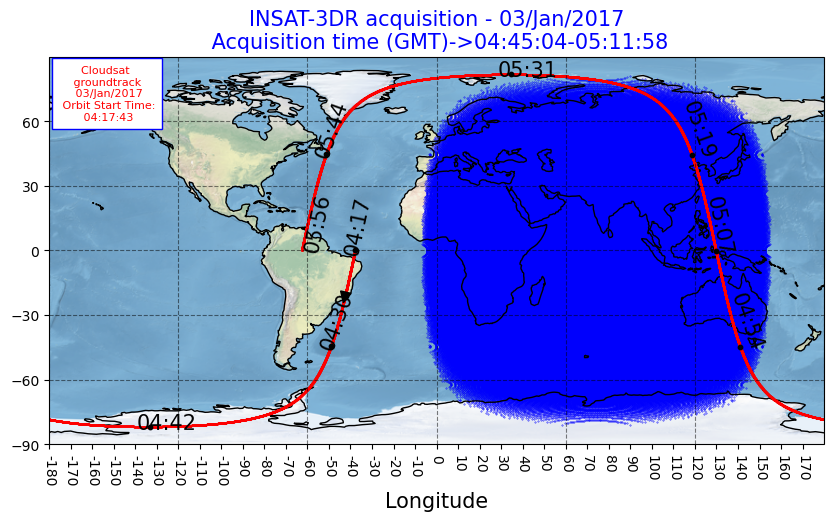

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
import pandas as pd
from pyhdf.SD import SD, SDC
from pyhdf import HDF, VS, V
from time import gmtime, strftime
import datetime
import time
import geopy.distance
import os
import sys

import geopy
#Code running in interactive mode
print("All imports successful")

insatfilepath = r'/data/debasish/insatdata/l1b/2017/jan2017/day03/3RIMG_03JAN2017_0445_L1B_STD_V01R00.h5'
csatfilepath= r'/data/debasish/cloudsatdata/cldclasslidar/2017/2017jan/003/2017003041743_56840_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E06_F01.hdf'

def groundtrackplotter(pathorfile,c='r', timestamp=True, passedaxis=None, baseimage=True, text=None, s=0.51,linewidths=0.51,arrow=True,arrow_color='black',arrow_width=0.0001,arrow_head_width=5,arrow_head_length=5
,time_label=True, time_label_color='black',time_label_fontsize=10,rotation=80, time_label_count=3):
    if type(pathorfile)==str:
        h=HDF.HDF(pathorfile)
    else:
        h=pathorfile

    def oneddata(searchdatasetlist):
        datasetlist=[]
        for i in searchdatasetlist:
            vs=h.vstart()
            xid=vs.find(i)
            dataid=vs.attach(xid)
            dataid.setfields(i)
            nrecs,_,_,_,_=dataid.inquire()
            data=dataid.read(nRec=nrecs)
            data=list(np.concatenate(data))
            datasetlist.append(data)
            dataid.detach()
            vs.end()
        return datasetlist

    longitude,latitude=oneddata(['Longitude','Latitude'])
#    fig=plt.figure(figsize=(10,10))
    if passedaxis==None:
        ax=plt.axes(projection=ccrs.PlateCarree())
    else:
        ax=passedaxis
    ax.coastlines()
    if baseimage==True:
        ax.stock_img()
    #Make gridlines color black
    ax.gridlines(color='black', alpha=0.5, linestyle='--')
#    ax.gridlines()
    ax.set_xticks(np.arange(-180, 180, 10), crs=ccrs.PlateCarree())
    ax.set_xticklabels(ax.get_xticks(), rotation=-90)
    ax.set_yticks(np.arange(-90, 90, 30), crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude',fontsize=15)

    ax.scatter(longitude,latitude,transform=ccrs.PlateCarree(),c=c,s=s,linewidths=linewidths)

    if arrow==True:
    #Put arrow at 2000th profile, given there are 36000 profiles
        ax.arrow(longitude[2000],latitude[2000],longitude[2000+5]-longitude[2000],latitude[2000+5]-latitude[2000],
        transform=ccrs.PlateCarree(),color=arrow_color,width=arrow_width,head_width=arrow_head_width,head_length=arrow_head_length)
    
    if time_label==True:
        #Put a time label along the track at #time_label_count uniform intervals
        start_time,differential_time=oneddata(['UTC_start','Profile_time'])
        start_time=start_time[0]
        #print(start_time)
        if timestamp==True:

            profile_time=[start_time+i for i in differential_time]
            profile_time_utc=[time.strftime('%H:%M', time.gmtime(i)) for i in profile_time]
            step=int(len(profile_time_utc)/(time_label_count))
            for i in range(0,int(len(profile_time_utc)-step),step):
                #Put a black dot at the time label

                ax.scatter(longitude[i],latitude[i],transform=ccrs.PlateCarree(),color=time_label_color,s=10)
                ax.text(longitude[i]-6,latitude[i]-1,profile_time_utc[i],transform=ccrs.PlateCarree(),color=time_label_color,fontsize=time_label_fontsize,
                rotation=np.rad2deg(np.arctan((latitude[i+5]-latitude[i])/(longitude[i+5]-longitude[i]))))

            #ax.scatter(longitude[-1],latitude[-1],transform=ccrs.PlateCarree(),color=time_label_color,s=10)
            ax.text(longitude[-1],latitude[-1],profile_time_utc[-1],transform=ccrs.PlateCarree(),color=time_label_color,fontsize=time_label_fontsize,
            rotation=np.rad2deg(np.arctan((latitude[-1-5]-latitude[-1])/(longitude[-1-5]-longitude[-1]))))
    #Get the data about date and time of the file from the filename

    filename=csatfilepath.split('/')[-1]
    year=(filename[0:4])
    daynumber=(filename[4:7])
    daynumber = int(daynumber.lstrip('0'))
    hour=filename[7:9]
    minute=filename[9:11]
    second=filename[11:13]
    #Get month and day from daynumber and year from existing library

    month = datetime.date.fromordinal(datetime.date(int(year), 1, 1).toordinal() + daynumber - 1).strftime('%b')
    day = datetime.date.fromordinal(datetime.date(int(year), 1, 1).toordinal() + daynumber - 1).strftime('%d')
    if text == None:
        text = ''

    #Put the text at upper left corner
    ax.text(-153,86,text+str(day)+"/"+month+"/"+str(year) +"\n Orbit Start Time:\n "+hour+":"+minute+":"+second,transform=ccrs.PlateCarree(),color='red',fontsize=8,horizontalalignment='center',verticalalignment='top',backgroundcolor='white',bbox=dict(facecolor='white', edgecolor='blue', pad=5.0))

    if passedaxis==None:
        plt.show()
        return
    else:
        return ax

#Make a blank axis, scatter INSAT data, then plot CSat data on top of it

fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection=ccrs.PlateCarree())

#Just plotting the latitude and longitude of INSAT data
insatfile=h5py.File(insatfilepath,'r')
latitudewv=np.ma.masked_equal(np.array(insatfile['Latitude_WV']),32767)/100
longitudewv=np.ma.masked_equal(np.array(insatfile['Longitude_WV']),32767)/100

ax.scatter(longitudewv,latitudewv,transform=ccrs.PlateCarree(),c='b',s=0.1,label='INSAT-3DR')
acq_start = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].replace('T','-') #To remove a T in the middle of string
start_time_obj=datetime.datetime.strptime(acq_start, "%d-%b-%Y-%H:%M:%S")
acq_end=str(insatfile.attrs['Acquisition_End_Time'])[2:-1].replace('T','-')
end_time_obj=datetime.datetime.strptime(acq_end, "%d-%b-%Y-%H:%M:%S")

#Get only date from the datetime object in the format of day/month/year
acq_date=start_time_obj.strftime("%d/%b/%Y")

#Put a title on the plot
plt.title('INSAT-3DR acquisition - '+acq_date+'\n Acquisition time (GMT)->'+start_time_obj.strftime("%H:%M:%S")+'-'+end_time_obj.strftime("%H:%M:%S"),fontsize=15,c='b')

ax=groundtrackplotter(csatfilepath,passedaxis=ax,time_label_count=8,time_label_color='black', time_label_fontsize=15,text="Cloudsat \n groundtrack \n ")

# Ask an input from the user, if input is escape, then exit the program

plt.show()

permission = input("Press c to continue else exit")

#Use this permission to execute the function below

def insatcsatcollocation(insatfilepath, csatfilepath):


#Data reading from Cloudsat file block
    
    csatfile=SD(csatfilepath, SDC.READ)
    h=HDF.HDF(csatfilepath)
    csatorbitnumber = int(csatfilepath.split('/')[-1].split('_')[1])

    #Reading cloudlayer, geogrphical parameters
    geofieldsearch=['Latitude','Longitude','DEM_elevation','Profile_time','Navigation_land_sea_flag','UTC_start']
    oneddatasearch=['Cloudlayer']

    geodatasetlist=[]
    oneddatasetlist=[]
    for i in geofieldsearch:
        vs=h.vstart()
        xid=vs.find(i)
        dataid=vs.attach(xid)
        dataid.setfields(i)
        nrecs,_,_,_,_=dataid.inquire()
        data=dataid.read(nRec=nrecs)
        data=list(np.concatenate(data))
        geodatasetlist.append(data)
    for i in oneddatasearch:
        vs=h.vstart()
        xid=vs.find(i)
        dataid=vs.attach(xid)
        dataid.setfields(i)
        nrecs,_,_,_,_=dataid.inquire()
        data=dataid.read(nRec=nrecs)
        data=list(np.concatenate(data))
        oneddatasetlist.append(data)
    
    csatlatitude=geodatasetlist[0] #Works fine, all the geo fields work fine
    csatlongitude=geodatasetlist[1]
    elevation=geodatasetlist[2] 
    diffprofiletime=geodatasetlist[3] #Difference between profile time and UTC start

    #Reading topography data, land sea flag
    csatlandsea=geodatasetlist[4] #1 = Land, 2 = Sea, 3 = Coast
    csatlandsea=np.array(csatlandsea,dtype=float)
    csatlandsea[csatlandsea==3]=1+0.5
    csatlandsea[csatlandsea==4]=2.0
    csatlandsea[csatlandsea==5]=1+0.5 #Just eliminating 4,5 and putting coast as 1.5

    #Time preparation for cloudsat data
    csatstart=geodatasetlist[5][0] #UTC start time of the orbit
    cloudlayer=oneddatasetlist[0] #No.of cloud layers
    csatprofiletime = [(i+csatstart) for i in diffprofiletime] #Profile time in seconds (UTC)
    
    #Reading cloud top and base data, and cloud type

    cloudtypearray = csatfile.select('CloudLayerType')[:,:]
    cloudtypearray = np.array(cloudtypearray,dtype=np.float32)
    cloudtypearray[cloudtypearray==-9]=np.nan
    
    cloudbasearray=csatfile.select('CloudLayerBase')[:,:]
    cloudbasearray[cloudbasearray==-99]=np.nan #-99.0 means undetermined

    cloudtoparray=csatfile.select('CloudLayerTop')[:,:]
    cloudtoparray[cloudtoparray==-99]=np.nan

    #Subtracting cloud base from cloud top to get cloud thickness
    cloudthicknessarray=cloudtoparray-cloudbasearray
    thicknessarray=np.nansum(cloudthicknessarray,axis=1)
    #nansum would give sum of 2 NaNs as 0, so we do corrections for that
    thicknessarray[np.array(cloudlayer)==-9.0]=np.nan #Otherwise, undetermined and clear pixels produce the same thickness i.e. 0

    print("Cloudsat data read")
    print("INSAT-3DR data reading started")

#Data reading from INSAT file block

    #INSAT-3DR time preparation
    insatfile = h5py.File(insatfilepath, 'r')
    acq_start = str(insatfile.attrs['Acquisition_Start_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_Start_Time'])[14:-1] #To remove a T in the middle of string
    start_time_obj=datetime.datetime.strptime(acq_start, "%d-%b-%Y-%H:%M:%S")
    insatstarttime=start_time_obj.hour*3600+start_time_obj.minute*60+start_time_obj.second
    
    acq_end = str(insatfile.attrs['Acquisition_End_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_End_Time'])[14:-1]
    end_time_obj=datetime.datetime.strptime(acq_end, "%d-%b-%Y-%H:%M:%S")
    insatendtime = end_time_obj.hour*3600+end_time_obj.minute*60+end_time_obj.second

    #Latitude and longitude of INSAT-3DR (*works fine)
    vislatitude=np.ma.masked_equal(insatfile["Latitude_VIS"],327670)/1000
    vislongitude=np.ma.masked_equal(insatfile["Longitude_VIS"],327670)/1000
    tirlongitude=np.ma.masked_equal(insatfile["Longitude"],32767)/100
    tirlatitude=np.ma.masked_equal(insatfile["Latitude"],32767)/100
    solarelevationarray=np.ma.masked_equal(insatfile["Sun_Elevation"][0],32767)/100
    satelevationarray=np.ma.masked_equal(insatfile["Sat_Elevation"][0],32767)/100

    #BT and Albedo data preparation (works fine)
    channel_listtir= ['IMG_MIR','IMG_TIR1','IMG_TIR2']
    btlist=[]

    for i in channel_listtir:
        img_arr=insatfile[i][0,:,:] 
        img_arr_fill=insatfile[i].attrs['_FillValue'][0]
        nanmask=(img_arr==img_arr_fill)
        btlut=np.array(insatfile[i+str('_TEMP')])
        def count2bt(count):
            return btlut[count]
        bt_array=count2bt(img_arr)
        bt_array[nanmask]=np.nan
        btlist.append(bt_array)

    img_arr=insatfile['IMG_VIS'][0,:,:]
    img_arr_fill=insatfile['IMG_VIS'].attrs['_FillValue'][0]
    nanmask=(img_arr==img_arr_fill)
    albedolut=np.array(insatfile['IMG_VIS_ALBEDO'])
    def count2albedo(count):
        return albedolut[count]
    albedo_array=count2albedo(img_arr)/100
    albedo_array[nanmask]=np.nan

    print("Brightness temperature and albedo data read")
    print("All data read")

    print("Beginning collocation")

#Collocation block

    #Time collocation
    timeindex=[]
    for i in range(len(csatprofiletime)): 
        if csatprofiletime[i]>insatstarttime and csatprofiletime[i]<insatendtime:
            timeindex.append(i)
    print("Time collocation done")
    print("time collocated csat profile min = {}, max = {}".format(min(timeindex),max(timeindex)))

    #Space collocation
    print("Beginning space collocation")
    landseacolllist = [] #Done
    thicknesscolllist = [] #Done
    albedocolllist = [] #Done
    btmircolllist = [] #Done
    bttir1colllist = [] #Done
    bttir2colllist = [] #Done
    solarelevationcolllist = [] #Done
    satelevationcolllist = [] #Done
    tircoordinsat = [] #Done
    tircoordcsat = []   #Done
    viscoordinsat = [] #Done
    viscoordcsat = [] #Done 
    tiroffsetlist= [] #Done
    visoffsetlist= [] #Done
    elevationcolllist = [] #Done
    profilenolist = [] #Done
    orbitnolist = [] #Done


    collocatedpointcount = 0
    for i in timeindex:
        #print("profile no. = {}".format(i),end="\r")
        profile = i
        print("current profile = {}".format(profile),end='\r')
        clat=csatlatitude[i]
        clon=csatlongitude[i]

        if clat<-60 or clat>60:
            continue
        if clon<0 or clon>140:
            continue
        height=elevation[i]
        thick = thicknessarray[i]
        landsea = csatlandsea[i]

        if np.isnan(thick):
            continue
    #Main collocation starts here
        combineddifftir = np.abs(tirlatitude-clat)+np.abs(tirlongitude-clon)
        indextir = np.nanargmin(combineddifftir)
        indextir = np.unravel_index(indextir,combineddifftir.shape)
        closestlattir = tirlatitude[indextir]
        closestlontir = tirlongitude[indextir]
        satelevation = satelevationarray[indextir]
        solarelevation = solarelevationarray[indextir]
        tiroffset = geopy.distance.distance((clat,clon),(closestlattir,closestlontir)).km

        combineddiffvis = np.abs(vislatitude-clat)+np.abs(vislongitude-clon)
        indexvis = np.nanargmin(combineddiffvis)
        indexvis = np.unravel_index(indexvis,combineddiffvis.shape)
        closestlatvis = vislatitude[indexvis]
        closestlonvis = vislongitude[indexvis]
        visoffset = geopy.distance.distance((clat,clon),(closestlatvis,closestlonvis)).km

        if tiroffset>1.0:
            continue
        if visoffset>1.0:
            continue

        btmir=btlist[0][indextir]
        bttir1=btlist[1][indextir]
        bttir2=btlist[2][indextir]
        albedo=albedo_array[indexvis]

        if np.isnan(btmir) or np.isnan(bttir1) or np.isnan(bttir2) or np.isnan(albedo):
            continue
        #Print the collocated data with /r to overwrite the previous line
        collocatedpointcount = collocatedpointcount + 1
        print("current profile = {}, insat coords {}, offset {} km,   points={}".format(profile,((np.round(closestlattir,2),np.round(closestlontir,2))),np.round(tiroffset,2),collocatedpointcount),end='\r')


        landseacolllist.append(landsea)
        thicknesscolllist.append(thick)
        albedocolllist.append(albedo)
        btmircolllist.append(btmir)
        bttir1colllist.append(bttir1)
        bttir2colllist.append(bttir2)
        solarelevationcolllist.append(solarelevation)
        satelevationcolllist.append(satelevation)
        tircoordinsat.append((closestlattir,closestlontir))
        tircoordcsat.append((clat,clon))
        viscoordinsat.append((closestlatvis,closestlonvis))
        viscoordcsat.append((clat,clon))
        tiroffsetlist.append(tiroffset)
        visoffsetlist.append(visoffset)
        elevationcolllist.append(height)
        profilenolist.append(profile)
        orbitnolist.append(csatorbitnumber)
        
    
    print("Space collocation done")

    #Make a dataframe of the collocated data
    collocateddata = pd.DataFrame({'btmir':btmircolllist,'bttir1':bttir1colllist,
                                   'bttir2':bttir2colllist,'albedo':albedocolllist,
                                   'thickness':thicknesscolllist,'insatcortir':tircoordinsat,
                                   'csatcortir':tircoordcsat,'tiroffset':tiroffsetlist,
                                   'insatcorvis':viscoordinsat,'csatcorvis':viscoordcsat,
                                   'visoffset':visoffsetlist,'solarelevation':solarelevationcolllist,
                                   'satelevation':satelevationcolllist,'elevation':elevationcolllist,
                                   'landsea':landseacolllist,'profile':profilenolist,
                                   'orbitnumber':orbitnolist})
    
    #Remove rows with any NaN values
    collocateddata = collocateddata.dropna()

    #Make a dataframe of the cloud type and base and top
    #Get a list of profile numbers from the collocated data and make c1type,c2type,c3type,c4type,c5type etc.
    #Then make a dataframe of the cloud type and base and top

    finalprofilelist = collocateddata['profile'].tolist()
    c1type = []
    c2type = []
    c3type = []
    c4type = []
    c5type = []
    c1base = []
    c2base = []
    c3base = []
    c4base = []
    c5base = []
    c1top = []
    c2top = []
    c3top = []
    c4top = []
    c5top = []

    for profile in finalprofilelist:
        c1type.append(cloudtypearray[profile][0])
        c2type.append(cloudtypearray[profile][1])
        c3type.append(cloudtypearray[profile][2])
        c4type.append(cloudtypearray[profile][3])
        c5type.append(cloudtypearray[profile][4])

        c1base.append(cloudbasearray[profile][0])
        c2base.append(cloudbasearray[profile][1])
        c3base.append(cloudbasearray[profile][2])
        c4base.append(cloudbasearray[profile][3])
        c5base.append(cloudbasearray[profile][4])

        c1top.append(cloudtoparray[profile][0])
        c2top.append(cloudtoparray[profile][1])
        c3top.append(cloudtoparray[profile][2])
        c4top.append(cloudtoparray[profile][3])
        c5top.append(cloudtoparray[profile][4])


    clouddataframe = pd.DataFrame({'c1type':c1type,'c1base':c1base, 'c1top':c1top,
                                    'c2type':c2type,'c2base':c2base, 'c2top':c2top,
                                    'c3type':c3type,'c3base':c3base, 'c3top':c3top,
                                    'c4type':c4type,'c4base':c4base, 'c4top':c4top,
                                    'c5type':c5type,'c5base':c5base, 'c5top':c5top})
    #Merge the two dataframes
    collocateddata = pd.concat([collocateddata,clouddataframe],axis=1)

    #Eliminating any duplicate values for tir coordinates
    
    print("Collocated data made into a dataframe @ shape {}, filesize {} MB".format(collocateddata.shape,sys.getsizeof(collocateddata)/1e6))

    insatdatetime = ''.join(insatfilepath.split('/')[-1].split('_')[1:3])
    filename = 'col'+insatdatetime+'_'+str(csatorbitnumber)+'.csv'

    adress = r'/data/debasish/collocations/2017/2017jan/day03'

    #Save the dataframe as a csv file in the folder
    #If file size <1MB, don't save
    if len(collocateddata)==0:
        print("No collocated data, not saved")
        pass
    else:
        collocateddata.to_csv(os.path.join(adress,filename),index=False)
        print("Collocated data saved as {}".format(filename)) 
    
if permission == 'c': #c for collocation
    insatcsatcollocation(insatfilepath,csatfilepath)

All imports successful


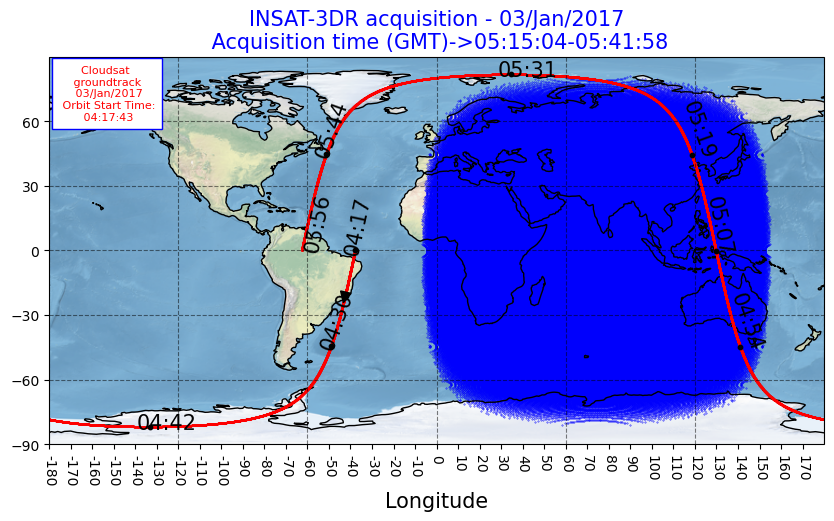

Cloudsat data read
INSAT-3DR data reading started
Brightness temperature and albedo data read
All data read
Beginning collocation
Time collocation done
time collocated csat profile min = 21501, max = 31588
Beginning space collocation
Space collocation done8, insat coords (59.87, 111.19), offset 0.31 km,   points=191
Collocated data made into a dataframe @ shape (191, 32), filesize 0.06432 MB
Collocated data saved as col03JAN20170515_56840.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
import pandas as pd
from pyhdf.SD import SD, SDC
from pyhdf import HDF, VS, V
from time import gmtime, strftime
import datetime
import time
import geopy.distance
import os
import sys

import geopy
#Code running in interactive mode
print("All imports successful")

insatfilepath = r'/data/debasish/insatdata/l1b/2017/jan2017/day03/3RIMG_03JAN2017_0515_L1B_STD_V01R00.h5'
csatfilepath= r'/data/debasish/cloudsatdata/cldclasslidar/2017/2017jan/003/2017003041743_56840_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E06_F01.hdf'

def groundtrackplotter(pathorfile,c='r', timestamp=True, passedaxis=None, baseimage=True, text=None, s=0.51,linewidths=0.51,arrow=True,arrow_color='black',arrow_width=0.0001,arrow_head_width=5,arrow_head_length=5
,time_label=True, time_label_color='black',time_label_fontsize=10,rotation=80, time_label_count=3):
    if type(pathorfile)==str:
        h=HDF.HDF(pathorfile)
    else:
        h=pathorfile

    def oneddata(searchdatasetlist):
        datasetlist=[]
        for i in searchdatasetlist:
            vs=h.vstart()
            xid=vs.find(i)
            dataid=vs.attach(xid)
            dataid.setfields(i)
            nrecs,_,_,_,_=dataid.inquire()
            data=dataid.read(nRec=nrecs)
            data=list(np.concatenate(data))
            datasetlist.append(data)
            dataid.detach()
            vs.end()
        return datasetlist

    longitude,latitude=oneddata(['Longitude','Latitude'])
#    fig=plt.figure(figsize=(10,10))
    if passedaxis==None:
        ax=plt.axes(projection=ccrs.PlateCarree())
    else:
        ax=passedaxis
    ax.coastlines()
    if baseimage==True:
        ax.stock_img()
    #Make gridlines color black
    ax.gridlines(color='black', alpha=0.5, linestyle='--')
#    ax.gridlines()
    ax.set_xticks(np.arange(-180, 180, 10), crs=ccrs.PlateCarree())
    ax.set_xticklabels(ax.get_xticks(), rotation=-90)
    ax.set_yticks(np.arange(-90, 90, 30), crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude',fontsize=15)

    ax.scatter(longitude,latitude,transform=ccrs.PlateCarree(),c=c,s=s,linewidths=linewidths)

    if arrow==True:
    #Put arrow at 2000th profile, given there are 36000 profiles
        ax.arrow(longitude[2000],latitude[2000],longitude[2000+5]-longitude[2000],latitude[2000+5]-latitude[2000],
        transform=ccrs.PlateCarree(),color=arrow_color,width=arrow_width,head_width=arrow_head_width,head_length=arrow_head_length)
    
    if time_label==True:
        #Put a time label along the track at #time_label_count uniform intervals
        start_time,differential_time=oneddata(['UTC_start','Profile_time'])
        start_time=start_time[0]
        #print(start_time)
        if timestamp==True:

            profile_time=[start_time+i for i in differential_time]
            profile_time_utc=[time.strftime('%H:%M', time.gmtime(i)) for i in profile_time]
            step=int(len(profile_time_utc)/(time_label_count))
            for i in range(0,int(len(profile_time_utc)-step),step):
                #Put a black dot at the time label

                ax.scatter(longitude[i],latitude[i],transform=ccrs.PlateCarree(),color=time_label_color,s=10)
                ax.text(longitude[i]-6,latitude[i]-1,profile_time_utc[i],transform=ccrs.PlateCarree(),color=time_label_color,fontsize=time_label_fontsize,
                rotation=np.rad2deg(np.arctan((latitude[i+5]-latitude[i])/(longitude[i+5]-longitude[i]))))

            #ax.scatter(longitude[-1],latitude[-1],transform=ccrs.PlateCarree(),color=time_label_color,s=10)
            ax.text(longitude[-1],latitude[-1],profile_time_utc[-1],transform=ccrs.PlateCarree(),color=time_label_color,fontsize=time_label_fontsize,
            rotation=np.rad2deg(np.arctan((latitude[-1-5]-latitude[-1])/(longitude[-1-5]-longitude[-1]))))
    #Get the data about date and time of the file from the filename

    filename=csatfilepath.split('/')[-1]
    year=(filename[0:4])
    daynumber=(filename[4:7])
    daynumber = int(daynumber.lstrip('0'))
    hour=filename[7:9]
    minute=filename[9:11]
    second=filename[11:13]
    #Get month and day from daynumber and year from existing library

    month = datetime.date.fromordinal(datetime.date(int(year), 1, 1).toordinal() + daynumber - 1).strftime('%b')
    day = datetime.date.fromordinal(datetime.date(int(year), 1, 1).toordinal() + daynumber - 1).strftime('%d')
    if text == None:
        text = ''

    #Put the text at upper left corner
    ax.text(-153,86,text+str(day)+"/"+month+"/"+str(year) +"\n Orbit Start Time:\n "+hour+":"+minute+":"+second,transform=ccrs.PlateCarree(),color='red',fontsize=8,horizontalalignment='center',verticalalignment='top',backgroundcolor='white',bbox=dict(facecolor='white', edgecolor='blue', pad=5.0))

    if passedaxis==None:
        plt.show()
        return
    else:
        return ax

#Make a blank axis, scatter INSAT data, then plot CSat data on top of it

fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection=ccrs.PlateCarree())

#Just plotting the latitude and longitude of INSAT data
insatfile=h5py.File(insatfilepath,'r')
latitudewv=np.ma.masked_equal(np.array(insatfile['Latitude_WV']),32767)/100
longitudewv=np.ma.masked_equal(np.array(insatfile['Longitude_WV']),32767)/100

ax.scatter(longitudewv,latitudewv,transform=ccrs.PlateCarree(),c='b',s=0.1,label='INSAT-3DR')
acq_start = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].replace('T','-') #To remove a T in the middle of string
start_time_obj=datetime.datetime.strptime(acq_start, "%d-%b-%Y-%H:%M:%S")
acq_end=str(insatfile.attrs['Acquisition_End_Time'])[2:-1].replace('T','-')
end_time_obj=datetime.datetime.strptime(acq_end, "%d-%b-%Y-%H:%M:%S")

#Get only date from the datetime object in the format of day/month/year
acq_date=start_time_obj.strftime("%d/%b/%Y")

#Put a title on the plot
plt.title('INSAT-3DR acquisition - '+acq_date+'\n Acquisition time (GMT)->'+start_time_obj.strftime("%H:%M:%S")+'-'+end_time_obj.strftime("%H:%M:%S"),fontsize=15,c='b')

ax=groundtrackplotter(csatfilepath,passedaxis=ax,time_label_count=8,time_label_color='black', time_label_fontsize=15,text="Cloudsat \n groundtrack \n ")

# Ask an input from the user, if input is escape, then exit the program

plt.show()

permission = input("Press c to continue else exit")

#Use this permission to execute the function below

def insatcsatcollocation(insatfilepath, csatfilepath):


#Data reading from Cloudsat file block
    
    csatfile=SD(csatfilepath, SDC.READ)
    h=HDF.HDF(csatfilepath)
    csatorbitnumber = int(csatfilepath.split('/')[-1].split('_')[1])

    #Reading cloudlayer, geogrphical parameters
    geofieldsearch=['Latitude','Longitude','DEM_elevation','Profile_time','Navigation_land_sea_flag','UTC_start']
    oneddatasearch=['Cloudlayer']

    geodatasetlist=[]
    oneddatasetlist=[]
    for i in geofieldsearch:
        vs=h.vstart()
        xid=vs.find(i)
        dataid=vs.attach(xid)
        dataid.setfields(i)
        nrecs,_,_,_,_=dataid.inquire()
        data=dataid.read(nRec=nrecs)
        data=list(np.concatenate(data))
        geodatasetlist.append(data)
    for i in oneddatasearch:
        vs=h.vstart()
        xid=vs.find(i)
        dataid=vs.attach(xid)
        dataid.setfields(i)
        nrecs,_,_,_,_=dataid.inquire()
        data=dataid.read(nRec=nrecs)
        data=list(np.concatenate(data))
        oneddatasetlist.append(data)
    
    csatlatitude=geodatasetlist[0] #Works fine, all the geo fields work fine
    csatlongitude=geodatasetlist[1]
    elevation=geodatasetlist[2] 
    diffprofiletime=geodatasetlist[3] #Difference between profile time and UTC start

    #Reading topography data, land sea flag
    csatlandsea=geodatasetlist[4] #1 = Land, 2 = Sea, 3 = Coast
    csatlandsea=np.array(csatlandsea,dtype=float)
    csatlandsea[csatlandsea==3]=1+0.5
    csatlandsea[csatlandsea==4]=2.0
    csatlandsea[csatlandsea==5]=1+0.5 #Just eliminating 4,5 and putting coast as 1.5

    #Time preparation for cloudsat data
    csatstart=geodatasetlist[5][0] #UTC start time of the orbit
    cloudlayer=oneddatasetlist[0] #No.of cloud layers
    csatprofiletime = [(i+csatstart) for i in diffprofiletime] #Profile time in seconds (UTC)
    
    #Reading cloud top and base data, and cloud type

    cloudtypearray = csatfile.select('CloudLayerType')[:,:]
    cloudtypearray = np.array(cloudtypearray,dtype=np.float32)
    cloudtypearray[cloudtypearray==-9]=np.nan
    
    cloudbasearray=csatfile.select('CloudLayerBase')[:,:]
    cloudbasearray[cloudbasearray==-99]=np.nan #-99.0 means undetermined

    cloudtoparray=csatfile.select('CloudLayerTop')[:,:]
    cloudtoparray[cloudtoparray==-99]=np.nan

    #Subtracting cloud base from cloud top to get cloud thickness
    cloudthicknessarray=cloudtoparray-cloudbasearray
    thicknessarray=np.nansum(cloudthicknessarray,axis=1)
    #nansum would give sum of 2 NaNs as 0, so we do corrections for that
    thicknessarray[np.array(cloudlayer)==-9.0]=np.nan #Otherwise, undetermined and clear pixels produce the same thickness i.e. 0

    print("Cloudsat data read")
    print("INSAT-3DR data reading started")

#Data reading from INSAT file block

    #INSAT-3DR time preparation
    insatfile = h5py.File(insatfilepath, 'r')
    acq_start = str(insatfile.attrs['Acquisition_Start_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_Start_Time'])[14:-1] #To remove a T in the middle of string
    start_time_obj=datetime.datetime.strptime(acq_start, "%d-%b-%Y-%H:%M:%S")
    insatstarttime=start_time_obj.hour*3600+start_time_obj.minute*60+start_time_obj.second
    
    acq_end = str(insatfile.attrs['Acquisition_End_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_End_Time'])[14:-1]
    end_time_obj=datetime.datetime.strptime(acq_end, "%d-%b-%Y-%H:%M:%S")
    insatendtime = end_time_obj.hour*3600+end_time_obj.minute*60+end_time_obj.second

    #Latitude and longitude of INSAT-3DR (*works fine)
    vislatitude=np.ma.masked_equal(insatfile["Latitude_VIS"],327670)/1000
    vislongitude=np.ma.masked_equal(insatfile["Longitude_VIS"],327670)/1000
    tirlongitude=np.ma.masked_equal(insatfile["Longitude"],32767)/100
    tirlatitude=np.ma.masked_equal(insatfile["Latitude"],32767)/100
    solarelevationarray=np.ma.masked_equal(insatfile["Sun_Elevation"][0],32767)/100
    satelevationarray=np.ma.masked_equal(insatfile["Sat_Elevation"][0],32767)/100

    #BT and Albedo data preparation (works fine)
    channel_listtir= ['IMG_MIR','IMG_TIR1','IMG_TIR2']
    btlist=[]

    for i in channel_listtir:
        img_arr=insatfile[i][0,:,:] 
        img_arr_fill=insatfile[i].attrs['_FillValue'][0]
        nanmask=(img_arr==img_arr_fill)
        btlut=np.array(insatfile[i+str('_TEMP')])
        def count2bt(count):
            return btlut[count]
        bt_array=count2bt(img_arr)
        bt_array[nanmask]=np.nan
        btlist.append(bt_array)

    img_arr=insatfile['IMG_VIS'][0,:,:]
    img_arr_fill=insatfile['IMG_VIS'].attrs['_FillValue'][0]
    nanmask=(img_arr==img_arr_fill)
    albedolut=np.array(insatfile['IMG_VIS_ALBEDO'])
    def count2albedo(count):
        return albedolut[count]
    albedo_array=count2albedo(img_arr)/100
    albedo_array[nanmask]=np.nan

    print("Brightness temperature and albedo data read")
    print("All data read")

    print("Beginning collocation")

#Collocation block

    #Time collocation
    timeindex=[]
    for i in range(len(csatprofiletime)): 
        if csatprofiletime[i]>insatstarttime and csatprofiletime[i]<insatendtime:
            timeindex.append(i)
    print("Time collocation done")
    print("time collocated csat profile min = {}, max = {}".format(min(timeindex),max(timeindex)))

    #Space collocation
    print("Beginning space collocation")
    landseacolllist = [] #Done
    thicknesscolllist = [] #Done
    albedocolllist = [] #Done
    btmircolllist = [] #Done
    bttir1colllist = [] #Done
    bttir2colllist = [] #Done
    solarelevationcolllist = [] #Done
    satelevationcolllist = [] #Done
    tircoordinsat = [] #Done
    tircoordcsat = []   #Done
    viscoordinsat = [] #Done
    viscoordcsat = [] #Done 
    tiroffsetlist= [] #Done
    visoffsetlist= [] #Done
    elevationcolllist = [] #Done
    profilenolist = [] #Done
    orbitnolist = [] #Done


    collocatedpointcount = 0
    for i in timeindex:
        #print("profile no. = {}".format(i),end="\r")
        profile = i
        print("current profile = {}".format(profile),end='\r')
        clat=csatlatitude[i]
        clon=csatlongitude[i]

        if clat<-60 or clat>60:
            continue
        if clon<0 or clon>140:
            continue
        height=elevation[i]
        thick = thicknessarray[i]
        landsea = csatlandsea[i]

        if np.isnan(thick):
            continue
    #Main collocation starts here
        combineddifftir = np.abs(tirlatitude-clat)+np.abs(tirlongitude-clon)
        indextir = np.nanargmin(combineddifftir)
        indextir = np.unravel_index(indextir,combineddifftir.shape)
        closestlattir = tirlatitude[indextir]
        closestlontir = tirlongitude[indextir]
        satelevation = satelevationarray[indextir]
        solarelevation = solarelevationarray[indextir]
        tiroffset = geopy.distance.distance((clat,clon),(closestlattir,closestlontir)).km

        combineddiffvis = np.abs(vislatitude-clat)+np.abs(vislongitude-clon)
        indexvis = np.nanargmin(combineddiffvis)
        indexvis = np.unravel_index(indexvis,combineddiffvis.shape)
        closestlatvis = vislatitude[indexvis]
        closestlonvis = vislongitude[indexvis]
        visoffset = geopy.distance.distance((clat,clon),(closestlatvis,closestlonvis)).km

        if tiroffset>1.0:
            continue
        if visoffset>1.0:
            continue

        btmir=btlist[0][indextir]
        bttir1=btlist[1][indextir]
        bttir2=btlist[2][indextir]
        albedo=albedo_array[indexvis]

        if np.isnan(btmir) or np.isnan(bttir1) or np.isnan(bttir2) or np.isnan(albedo):
            continue
        #Print the collocated data with /r to overwrite the previous line
        collocatedpointcount = collocatedpointcount + 1
        print("current profile = {}, insat coords {}, offset {} km,   points={}".format(profile,((np.round(closestlattir,2),np.round(closestlontir,2))),np.round(tiroffset,2),collocatedpointcount),end='\r')


        landseacolllist.append(landsea)
        thicknesscolllist.append(thick)
        albedocolllist.append(albedo)
        btmircolllist.append(btmir)
        bttir1colllist.append(bttir1)
        bttir2colllist.append(bttir2)
        solarelevationcolllist.append(solarelevation)
        satelevationcolllist.append(satelevation)
        tircoordinsat.append((closestlattir,closestlontir))
        tircoordcsat.append((clat,clon))
        viscoordinsat.append((closestlatvis,closestlonvis))
        viscoordcsat.append((clat,clon))
        tiroffsetlist.append(tiroffset)
        visoffsetlist.append(visoffset)
        elevationcolllist.append(height)
        profilenolist.append(profile)
        orbitnolist.append(csatorbitnumber)
        
    
    print("Space collocation done")

    #Make a dataframe of the collocated data
    collocateddata = pd.DataFrame({'btmir':btmircolllist,'bttir1':bttir1colllist,
                                   'bttir2':bttir2colllist,'albedo':albedocolllist,
                                   'thickness':thicknesscolllist,'insatcortir':tircoordinsat,
                                   'csatcortir':tircoordcsat,'tiroffset':tiroffsetlist,
                                   'insatcorvis':viscoordinsat,'csatcorvis':viscoordcsat,
                                   'visoffset':visoffsetlist,'solarelevation':solarelevationcolllist,
                                   'satelevation':satelevationcolllist,'elevation':elevationcolllist,
                                   'landsea':landseacolllist,'profile':profilenolist,
                                   'orbitnumber':orbitnolist})
    
    #Remove rows with any NaN values
    collocateddata = collocateddata.dropna()

    #Make a dataframe of the cloud type and base and top
    #Get a list of profile numbers from the collocated data and make c1type,c2type,c3type,c4type,c5type etc.
    #Then make a dataframe of the cloud type and base and top

    finalprofilelist = collocateddata['profile'].tolist()
    c1type = []
    c2type = []
    c3type = []
    c4type = []
    c5type = []
    c1base = []
    c2base = []
    c3base = []
    c4base = []
    c5base = []
    c1top = []
    c2top = []
    c3top = []
    c4top = []
    c5top = []

    for profile in finalprofilelist:
        c1type.append(cloudtypearray[profile][0])
        c2type.append(cloudtypearray[profile][1])
        c3type.append(cloudtypearray[profile][2])
        c4type.append(cloudtypearray[profile][3])
        c5type.append(cloudtypearray[profile][4])

        c1base.append(cloudbasearray[profile][0])
        c2base.append(cloudbasearray[profile][1])
        c3base.append(cloudbasearray[profile][2])
        c4base.append(cloudbasearray[profile][3])
        c5base.append(cloudbasearray[profile][4])

        c1top.append(cloudtoparray[profile][0])
        c2top.append(cloudtoparray[profile][1])
        c3top.append(cloudtoparray[profile][2])
        c4top.append(cloudtoparray[profile][3])
        c5top.append(cloudtoparray[profile][4])


    clouddataframe = pd.DataFrame({'c1type':c1type,'c1base':c1base, 'c1top':c1top,
                                    'c2type':c2type,'c2base':c2base, 'c2top':c2top,
                                    'c3type':c3type,'c3base':c3base, 'c3top':c3top,
                                    'c4type':c4type,'c4base':c4base, 'c4top':c4top,
                                    'c5type':c5type,'c5base':c5base, 'c5top':c5top})
    #Merge the two dataframes
    collocateddata = pd.concat([collocateddata,clouddataframe],axis=1)

    #Eliminating any duplicate values for tir coordinates
    
    print("Collocated data made into a dataframe @ shape {}, filesize {} MB".format(collocateddata.shape,sys.getsizeof(collocateddata)/1e6))

    insatdatetime = ''.join(insatfilepath.split('/')[-1].split('_')[1:3])
    filename = 'col'+insatdatetime+'_'+str(csatorbitnumber)+'.csv'

    adress = r'/data/debasish/collocations/2017/2017jan/day03'

    #Save the dataframe as a csv file in the folder
    #If file size <1MB, don't save
    if len(collocateddata)==0:
        print("No collocated data, not saved")
        pass
    else:
        collocateddata.to_csv(os.path.join(adress,filename),index=False)
        print("Collocated data saved as {}".format(filename)) 
    
if permission == 'c': #c for collocation
    insatcsatcollocation(insatfilepath,csatfilepath)